# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [25]:
# TODO: code and runtime results

In [420]:
import pandas as pd
# import the seaborn module
import seaborn as sns
# import the matplotlib module
import matplotlib.pyplot as plt
import datetime  
import numpy as np
from matplotlib.ticker import PercentFormatter
import os
import missingno as msno # visualize the distribution of NaN values
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [424]:
#reading the file train_(identity,transaction)
train_idt= pd.read_csv("train_identity.csv")
train_txn= pd.read_csv("train_transaction.csv")

In [28]:
#reading the file test_(identity,transaction)
test_idt= pd.read_csv('test_identity.csv')
test_txn= pd.read_csv('test_transaction.csv')


In [29]:
#Filtering out required columns from idt
idt_filt = ['TransactionID','DeviceType','DeviceInfo']
train_idt = train_idt[idt_filt]
test_idt = test_idt[idt_filt]
 

In [30]:
#Filtering out required columns from txn
train_txn_filt = ['TransactionID','TransactionDT','TransactionAmt','ProductCD','card4','card6','P_emaildomain','R_emaildomain','addr1','addr2','dist1','dist2','isFraud']
train_txn = train_txn[train_txn_filt]

test_txn_filt = ['TransactionID','TransactionDT','TransactionAmt','ProductCD','card4','card6','P_emaildomain','R_emaildomain','addr1','addr2','dist1','dist2']
test_txn = test_txn[test_txn_filt]



In [31]:
#merge both train files idt and txn based on common entity 'TransactionID'
train_df = pd.merge(train_txn, train_idt,on='TransactionID', how='left')
#train_df=train_df.drop_duplicates()

#merge both test files idt and txn based on common entity 'TransactionID'
test_df = pd.merge(test_txn,test_idt, on='TransactionID', how='left')

print('Shape of Training Set: ' + str(train_df.shape))
print('Shape of Test Set: ' + str(test_df.shape))

Shape of Training Set: (590540, 15)
Shape of Test Set: (506691, 14)


In [32]:
del train_idt, train_txn, test_idt, test_txn

Text(0.5, 1.0, 'Data Completenss Check in Training Set')

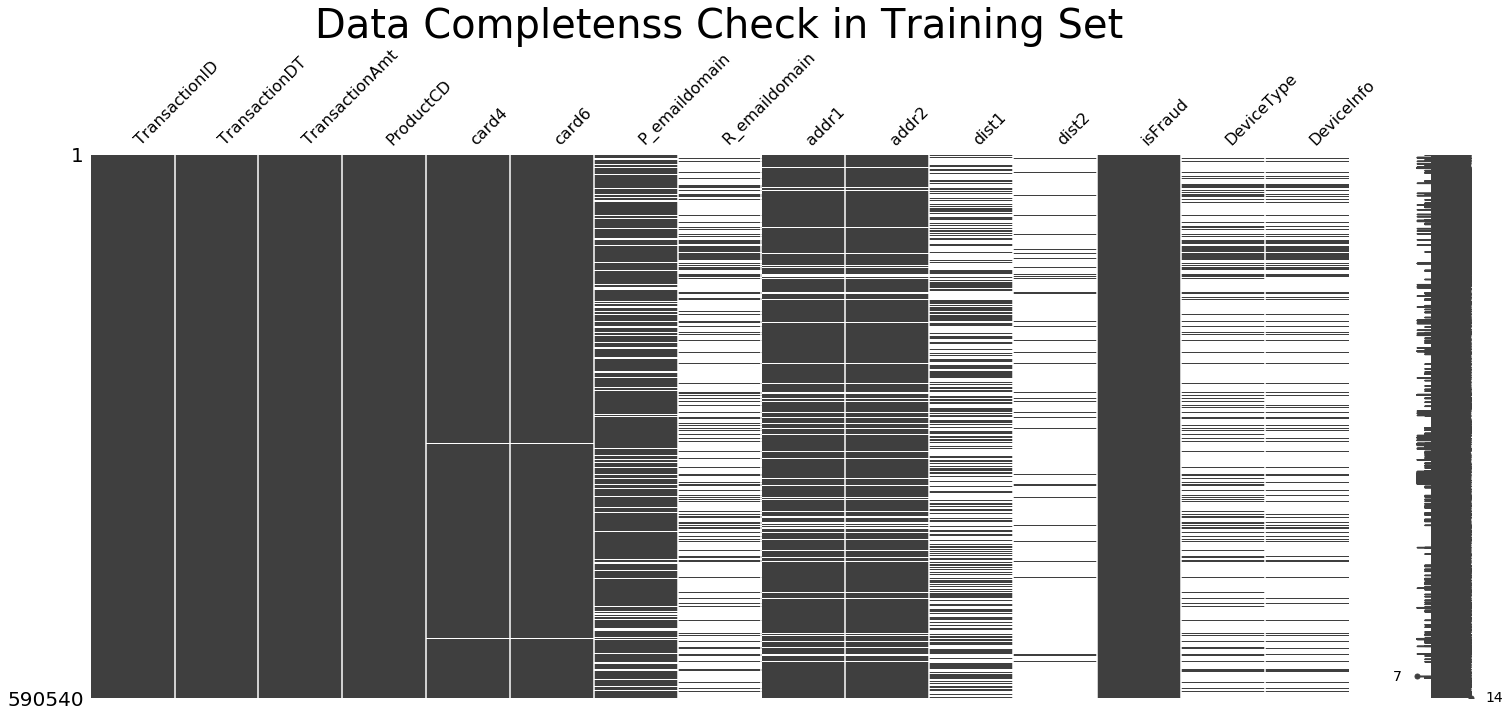

In [33]:
#Checking Nullity and Data Completeness
import missingno as msno
msno.matrix(train_df)
plt.title('Data Completenss Check in Training Set', size = 40)

**-->From Above plot we observe that dist2, dist1, R_emaildomain, DeviceType, DeviceInfo are alomst empty, lets investigate further to see what number of non null values are present in each variable**

Percentage Null Values in each column
TransactionID      0.00
TransactionDT      0.00
TransactionAmt     0.00
ProductCD          0.00
card4              0.27
card6              0.27
P_emaildomain     15.99
R_emaildomain     76.75
addr1             11.13
addr2             11.13
dist1             59.65
dist2             93.63
isFraud            0.00
DeviceType        76.16
DeviceInfo        79.91
dtype: float64


Text(0.5, 1.0, 'Visualization of Nullity by column in Training Set')

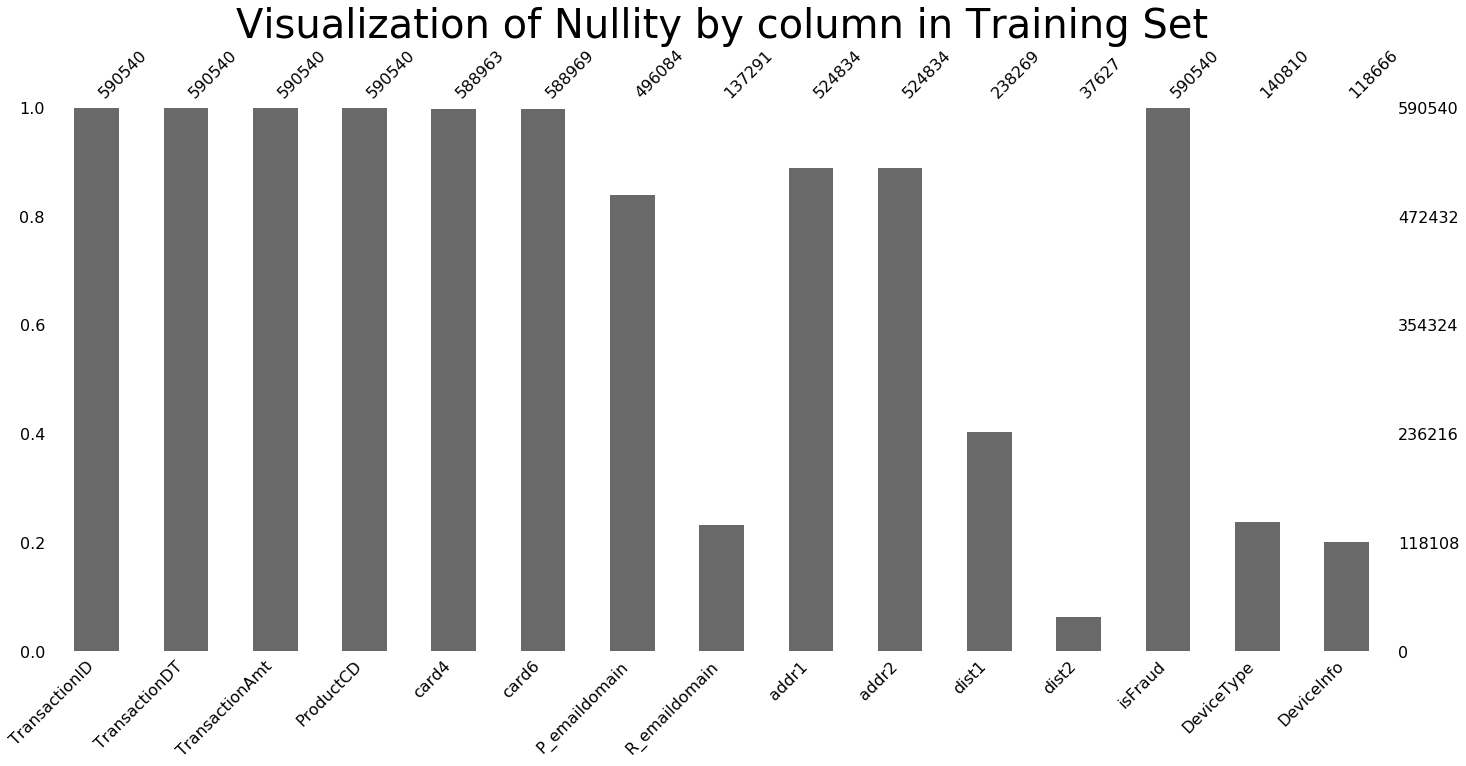

In [34]:
from tabulate import tabulate
print("Percentage Null Values in each column")
print(train_df.isna().mean().round(4) * 100)

msno.bar(train_df)
plt.title('Visualization of Nullity by column in Training Set', size = 40)

**-->We clearly observe that columns dist2 has 94% nullls, dist1 has 60% nulls, DeviceType has 76% nulls, DeviceInfo has 80% nulls, Remaildomain has 77% nulls, investigating further how does the nullity of one column are related to other columns**

Text(0.5, 1, 'Nullity correlation: Checking how strongly the presence or absence of one variable affects the presence of another')

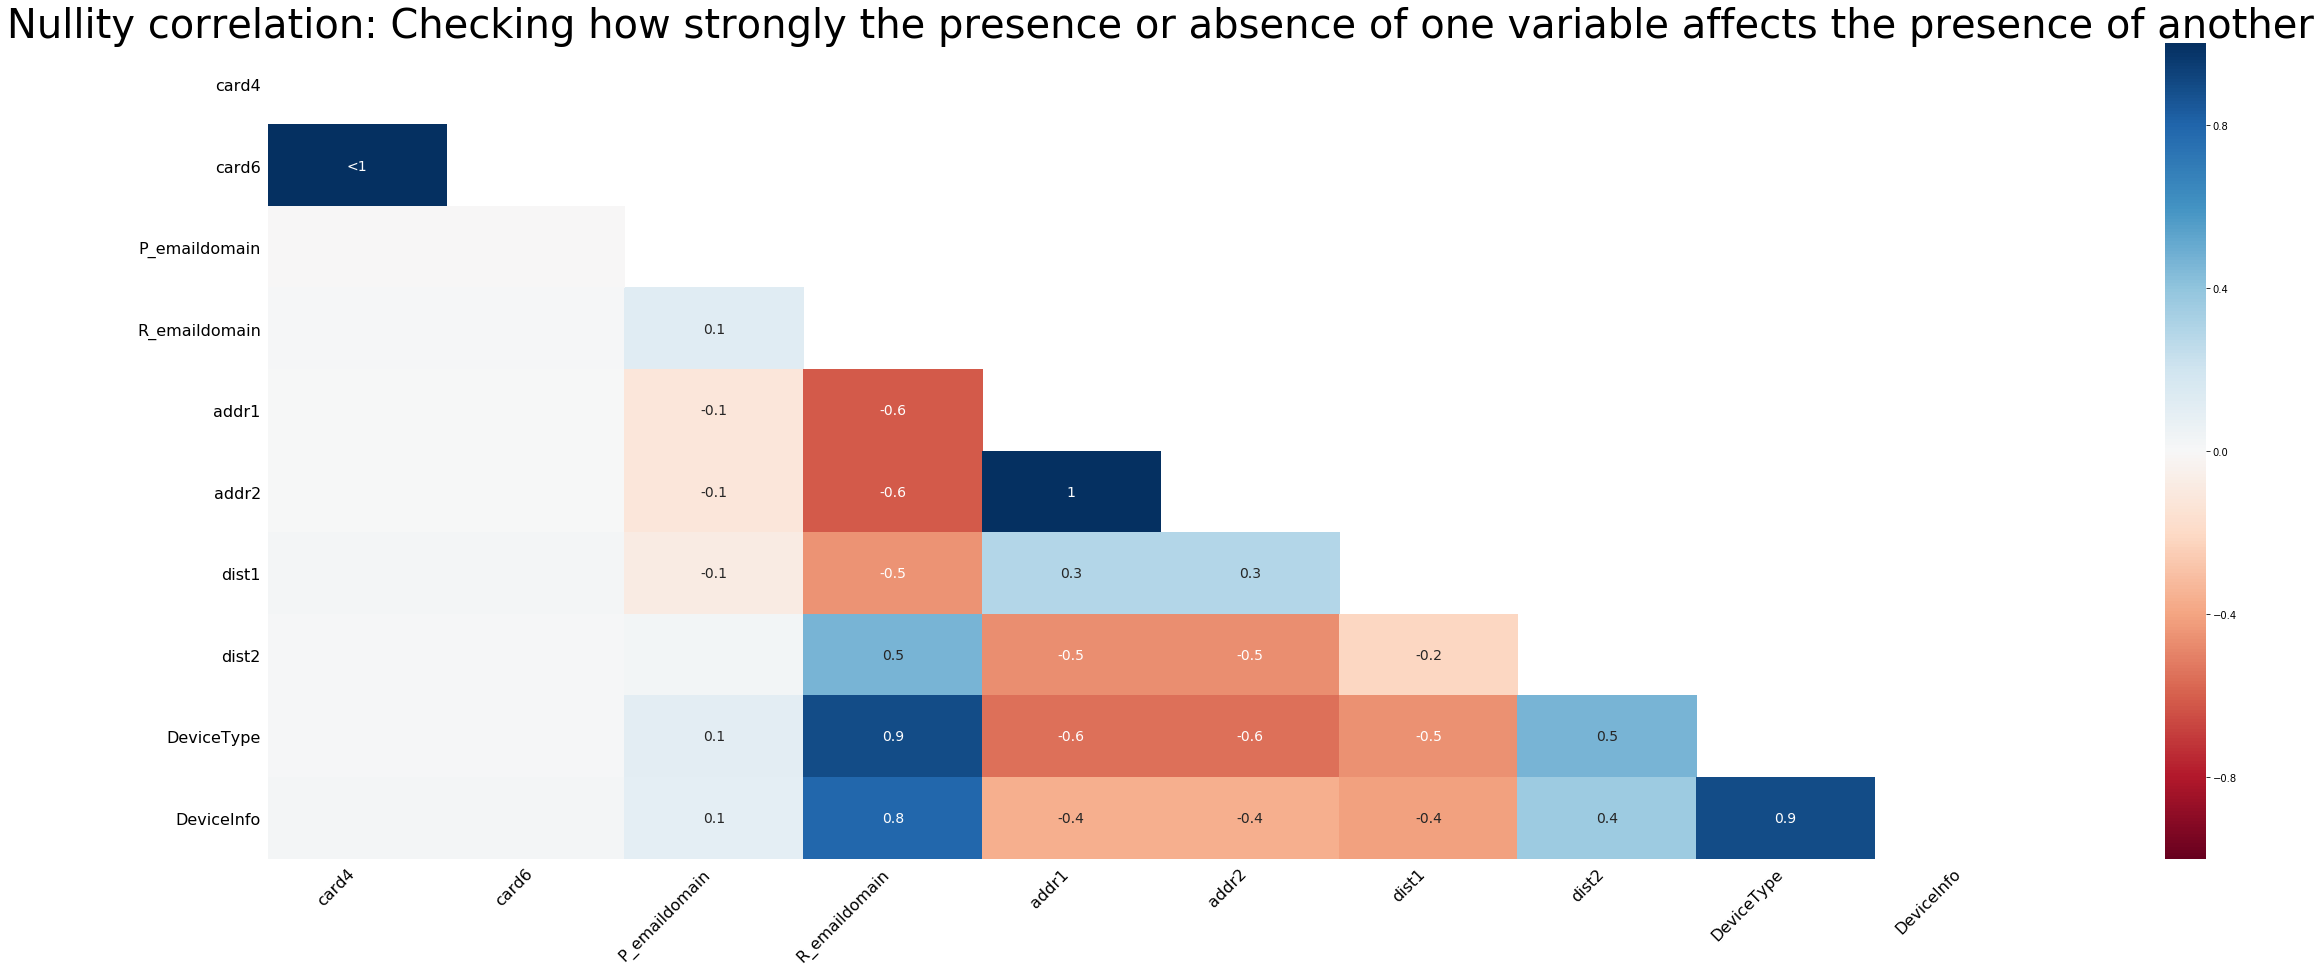

In [35]:
msno.heatmap(train_df,figsize= (40,15))
plt.title('Nullity correlation: Checking how strongly the presence or absence of one variable affects the presence of another', size = 40)

In [36]:
#Dropping dist1, dist2, DeviceType,DeviceInfo, R_emaildomain as they are mostly NUll Values
train_df= train_df.drop(['dist1','dist2','DeviceType','DeviceInfo','R_emaildomain'], axis=1)
test_df = test_df.drop(['dist1','dist2','DeviceType','DeviceInfo','R_emaildomain'], axis=1)

train_df['addr1']= train_df['addr1'].astype(str)
train_df['addr2']= train_df['addr2'].astype(str)

test_df['addr1']= test_df['addr1'].astype(str)
test_df['addr2']= test_df['addr2'].astype(str)


Reducing the Memory size by converting the columns to appropriate type and replacing null, NaN values of numerical varibales by -999

In [37]:
def reduce_memory(df):
    original_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of orginal properties dataframe is :",original_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            #Integer does not support NA, therefore, NA needs to be filled
            
            if not np.isfinite(df[col]).all(): 
               NAlist.append(col)
               df[col].fillna(-999,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] =df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/original_mem_usg,"% of the initial size")
    return df

#Reducing Memory For training and test data
train=reduce_memory(train_df)

test=reduce_memory(test_df)


Memory usage of orginal properties dataframe is : 49.560089111328125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  38.859615325927734  MB
This is  78.4090909090909 % of the initial size
Memory usage of orginal properties dataframe is : 38.65745544433594  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  32.85883712768555  MB
This is  85.0 % of the initial size


In [38]:
#Keeping a backup for train and test 
train_bkup = train.copy()
test_bkup = test.copy()

In [39]:
#Run this cell in case test and train needs to be brought back to original shape
train=train_bkup.copy()
test= test_bkup.copy()

## Part 1 Continued...
Filter out your data to examine just the fraudulent transactions.
For each field above, examine the distribution of the values, and explain any interesting insight you get from this.
How do the distributions on fraudulent transactions compare to the non-fraudulent ones?

Checking Numeric AND Categorical Columns

In [40]:
cols=train.columns
num_cols=train._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))
print("Numeric Columns:",num_cols)
print("Categoric Columns:",cat_cols)


Numeric Columns: Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'isFraud'], dtype='object')
Categoric Columns: ['card6', 'ProductCD', 'card4', 'addr1', 'addr2', 'P_emaildomain']


**To handle Time period of the data, let's look at the country code distribution of the data**

In [41]:
country_zone = train.groupby(['addr2'])['TransactionID'].count()
cnt= pd.DataFrame(country_zone*100 / country_zone.sum())
cnt=cnt.reset_index()
cnt.columns = ['addr2', 'Percentage_Transactions']


df1 = cnt.sort_values('Percentage_Transactions',ascending = False)
df1.head(5)

,addr2,Percentage_Transactions
65,87.0,88.136451
74,nan,11.126427
43,60.0,0.522234
71,96.0,0.108037
23,32.0,0.015410


**We can see that 88% of the data comes from Country code 87 and 11 % are null which accounts to 99% of all data so its safe to take any base timesamp and convert TimestampDt to date format**

**The TransactionDT feature is timedelta from a given reference datetime (not an actual timestamp). Let's assume the start time is from Jan 19,2019**

In [42]:
st_dt = datetime.datetime.strptime('2019-01-19', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (st_dt + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (st_dt + datetime.timedelta(seconds = x)))

#Converting Date to 'yy-mm-dd hh-mm-ss' format
#train_df['TransactionDT']= pd.to_datetime(train_df['TransactionDT'],unit='s')

**Checking Percentage of Fraud Samples in the training Set**

Total Data frame Shape: (590540, 10)
Fraud_Txns Data frame Shape: (20663, 10)
Non_Fraud_Txns Data frame Shape: (569877, 10)



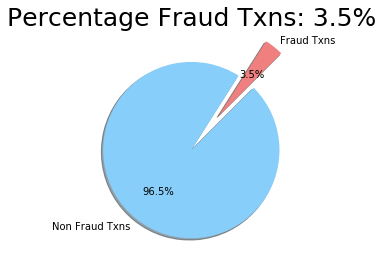

In [43]:
#Filtering Fraud and nonFraud Transactions
fraud_txn = train.loc[train['isFraud'] == 1]
non_fraud_txn = train.loc[train['isFraud'] == 0]

print('Total Data frame Shape: '+ str(train.shape))
print('Fraud_Txns Data frame Shape: ' + str(fraud_txn.shape))
print('Non_Fraud_Txns Data frame Shape: ' + str(non_fraud_txn.shape))

print('')
total_rws= train.shape[0]
fraud_rws= fraud_txn.shape[0]

plt.title('Percentage Fraud Txns: '+ str(round(fraud_rws*100/total_rws,2))+'%', size = 25)


import matplotlib.pyplot as plt

# Data to plot
labels = 'Fraud Txns', 'Non Fraud Txns'
sizes = [fraud_rws,total_rws-fraud_rws]
colors = ['lightcoral', 'lightskyblue']
explode = (0.5, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=45)
plt.axis('equal')
plt.show()

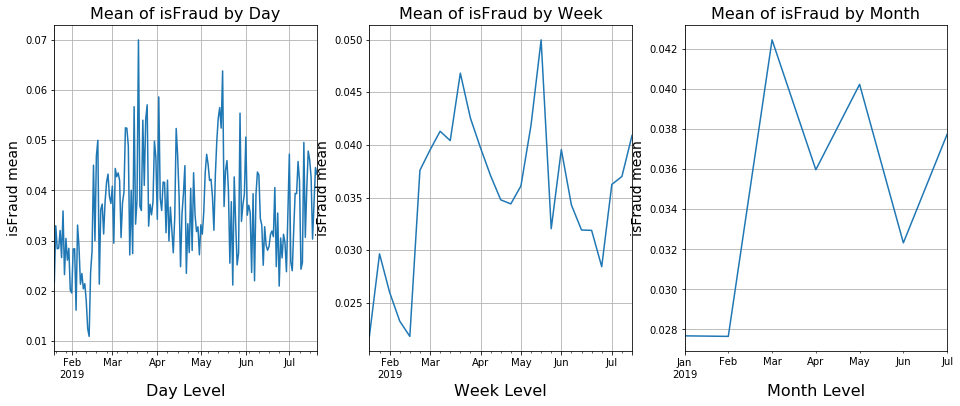

In [44]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 6)) 
gs = gridspec.GridSpec(1, 3)

axes = plt.subplot(gs[0, 0])
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14)
axes.set_title('Mean of isFraud by Day', fontsize=16)
axes.set_xlabel('Day Level', fontsize=16)
plt.grid(True)

fig.add_subplot(axes)


axes = plt.subplot(gs[0, 1])
train.set_index('TransactionDT').resample('W').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by Week', fontsize=16)
axes.set_xlabel('Week Level', fontsize=16)
plt.grid(True)

fig.add_subplot(axes)

axes = plt.subplot(gs[0, 2])
train.set_index('TransactionDT').resample('M').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by Month', fontsize=16)
axes.set_xlabel('Month Level', fontsize=16)
plt.grid(True)

fig.add_subplot(axes)

**From above we observe the following :
--> The probaility of Fraud spikes at the mid of the month
--> It will be interesting to see if week of the month plays a role in determining Fraud**


# Plotting Transaction Amount for Fraud v/s Non Fraud for all the categorical Variable

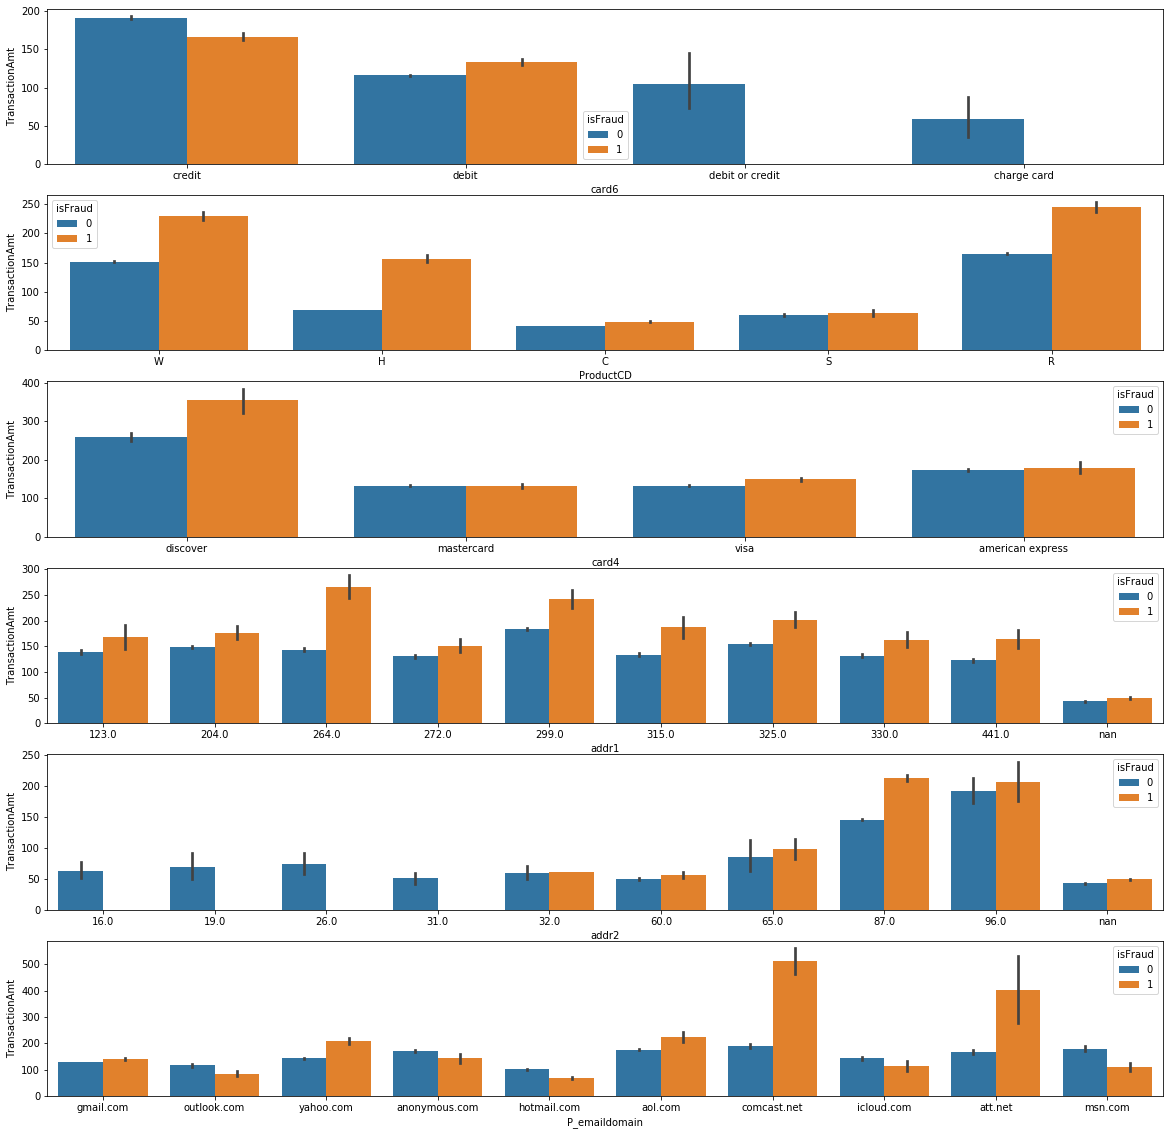

In [46]:
fig = plt.figure(figsize=(20, 20))

tot_plots=len(cat_cols)
i=1
for var in cat_cols:
    
    plt.subplot(tot_plots, 1, i)
    pick=train[var].value_counts()[:10].index    
    temp=train.loc[train[var].isin(pick)]
    sns.barplot(x=var, y="TransactionAmt",hue="isFraud",data=temp)
    i=i+1


# % Fraud on each category Level

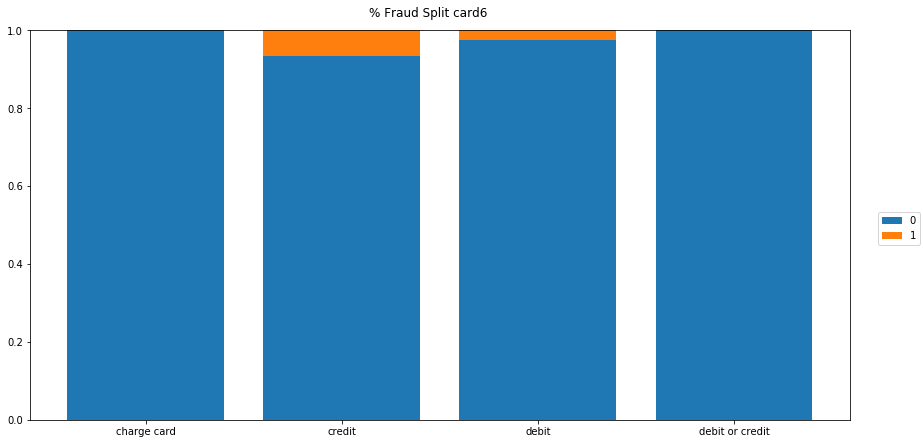

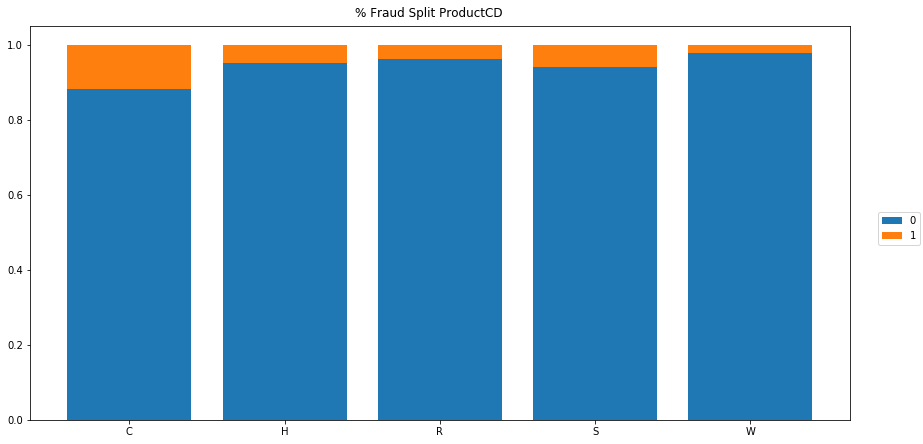

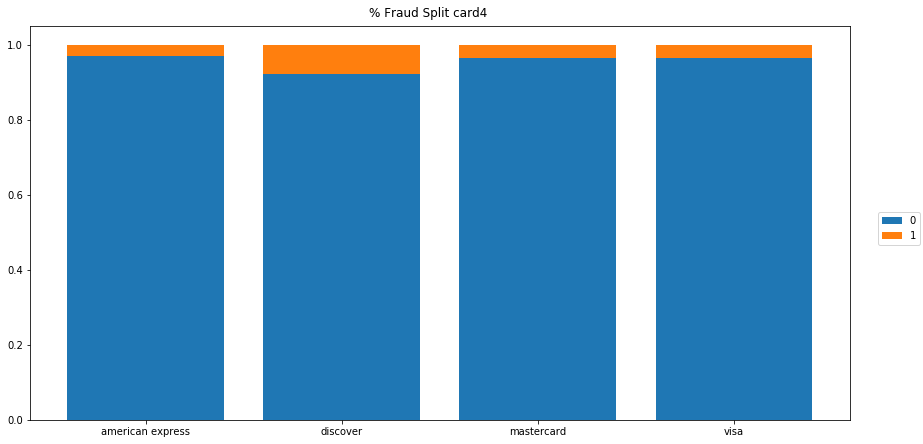

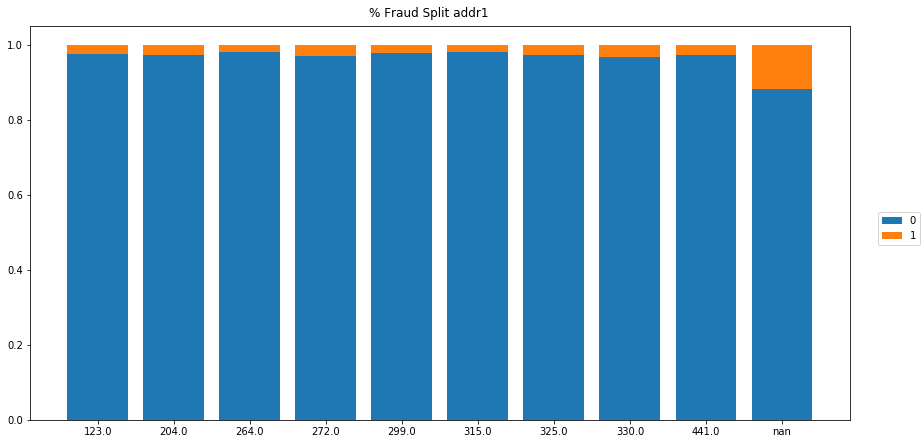

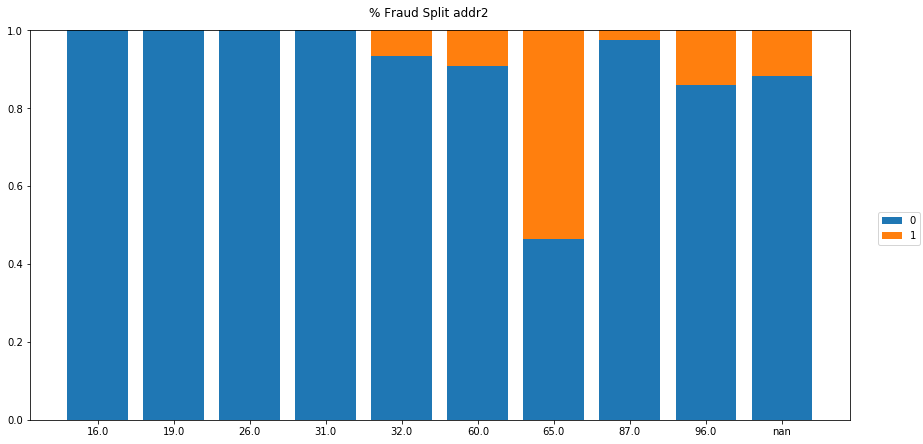

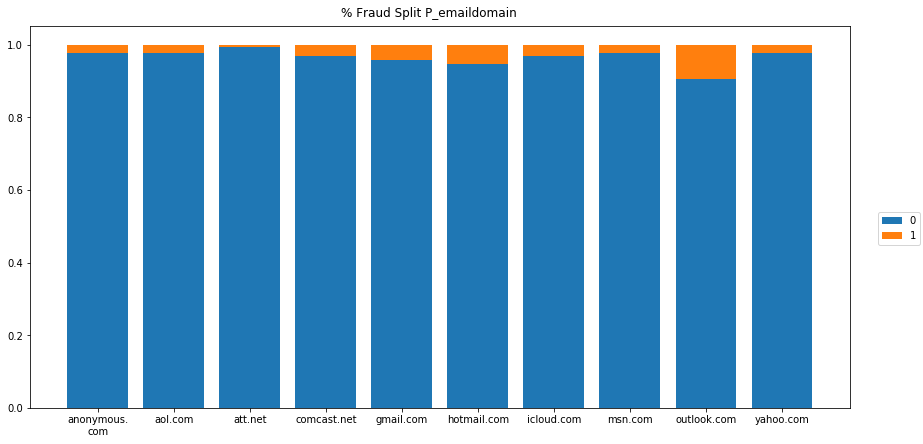

In [47]:
import dexplot as dxp

for var in cat_cols:
    #Selecting Top 10 most used var
    pick=train[var].value_counts()[:10].index    
    temp=train.loc[train[var].isin(pick)]
    dxp.aggplot(agg=var, data=temp,hue='isFraud', normalize=var,stacked=True,title="% Fraud Split " + var)
    

# Checking the Median Transaction Amount across all cateogries to determine if there are any alerts

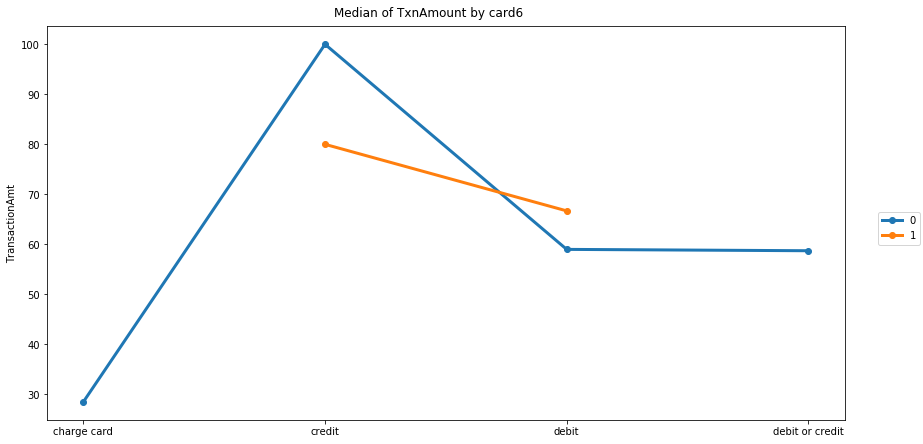

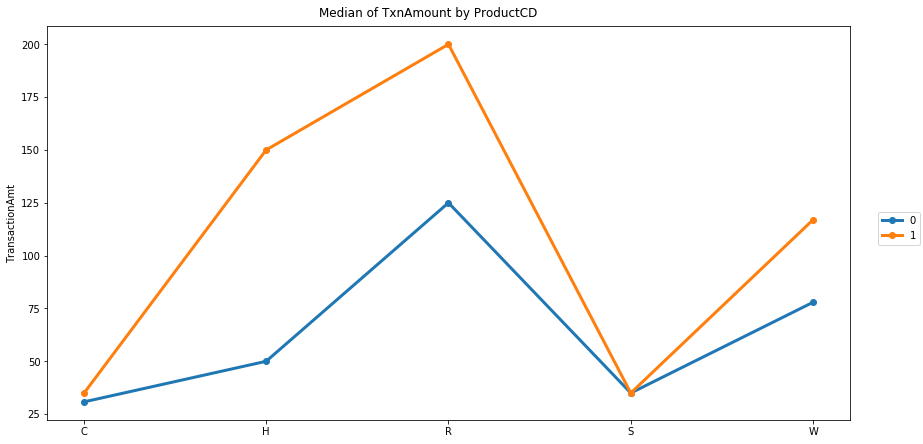

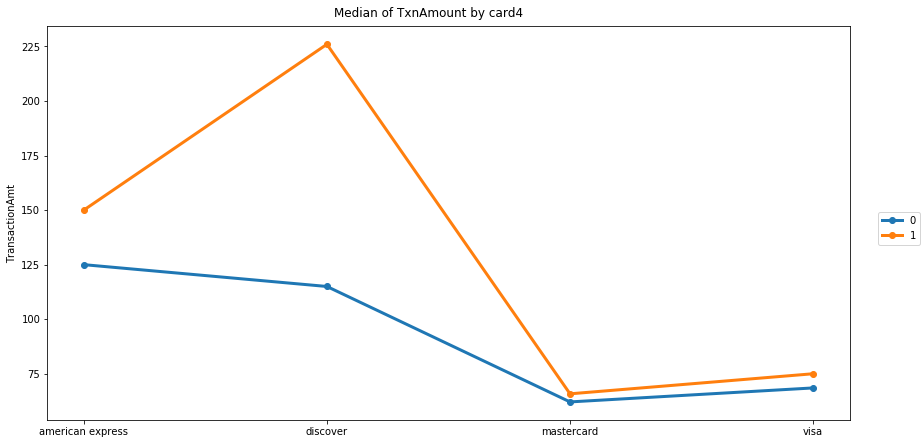

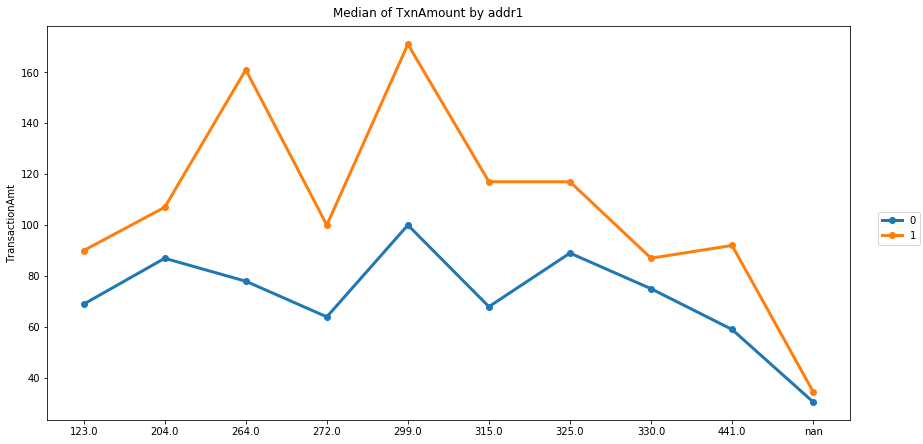

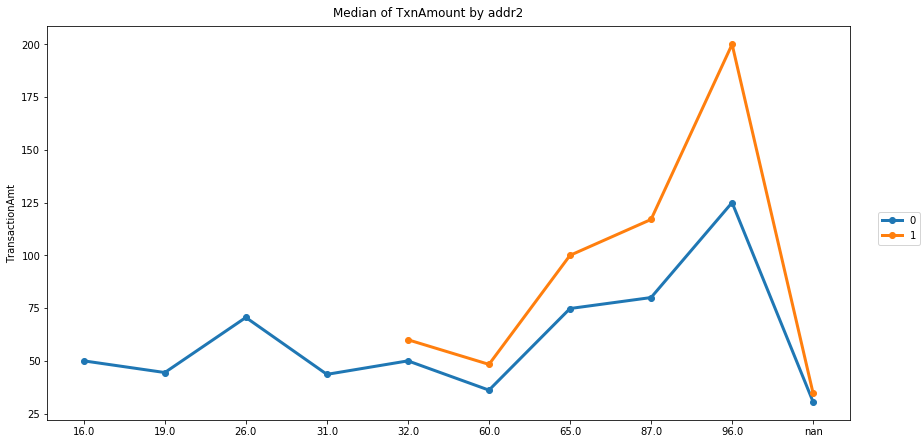

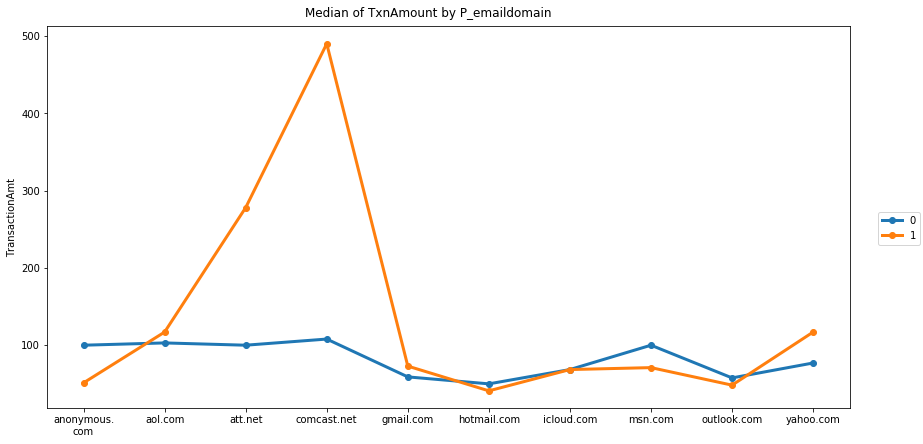

In [48]:
for var in cat_cols:
    #Selecting Top 10 most used var
    pick=train[var].value_counts()[:10].index    
    temp=train.loc[train[var].isin(pick)]
    dxp.aggplot(agg='TransactionAmt', data=temp, groupby=var, hue='isFraud', kind='line', aggfunc='median',title="Median of TxnAmount by " + var)
  

## Part 2 - Transaction Frequency

In [49]:
# TODO: code to generate the frequency graph


The addr2 field gives a code (but not name) associated with the country of the purchaser.
TransactionDT shows the time passed from some reference for each transaction.
By looking at the time of day of the transactions, we can infer what waking hours are associated with the country
relative to the reference time. Analyze the frequency distribution of transactions by time for the most frequent
country code, as per the addr2 field. Plot this distribution. Explain your findings.  


In [50]:
#Filtering only addr2 and Date columns for ditribution visualization
addr2_dt = train[['addr2','TransactionDT']]
addr2_dt= pd.DataFrame(addr2_dt)


In [51]:
#Adding hour column 
import datetime  
addr2_dt['hours'] = addr2_dt.TransactionDT.dt.hour

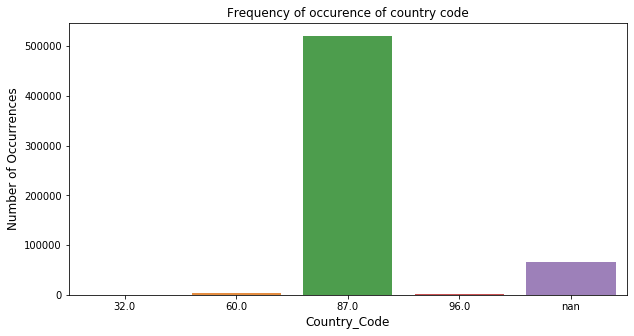

In [52]:
# Plotting a bar graph of the number of occurences of each unique addr2 in the column 'addr2'
addr2_count  = addr2_dt['addr2'].value_counts()
addr2_count = addr2_count[:5,]
plt.figure(figsize=(10,5))
sns.barplot(addr2_count.index, addr2_count.values, alpha=0.9)
plt.title('Frequency of occurence of country code')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Country_Code', fontsize=12)
plt.show()

# From above graph we observe that addr2 = "87" is the most frequent country code

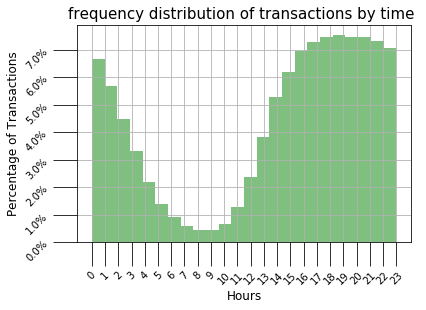

In [53]:
freq_country= addr2_dt.loc[addr2_dt['addr2'] == '87.0']['hours']
#.hist(column='hours', bins=24)

### Plotting the PDF 
plt.hist(freq_country, weights=np.ones(len(freq_country)) / len(freq_country),bins =24,density=True, histtype='stepfilled',
                           cumulative=0, label='Empirical',facecolor='g', alpha=0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('frequency distribution of transactions by time ',fontsize=15)
plt.ylabel('Percentage of Transactions', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.xticks(np.arange(0,24,1)) 
plt.grid(True)
plt.tick_params(axis ='x', rotation = 45,length =24) 
plt.tick_params(axis ='y', rotation = 45,length =24) 


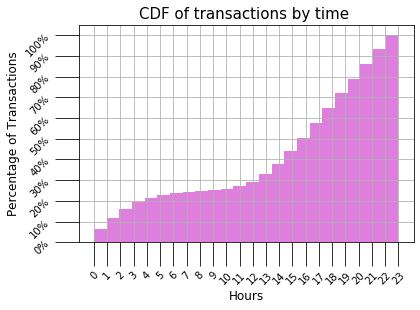

In [54]:
### Plotting the PDF 
plt.hist(freq_country, weights=np.ones(len(freq_country)) / len(freq_country),bins =24,density=True, histtype='stepfilled',
                           cumulative=1, label='Empirical',facecolor='m', alpha=0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('CDF of transactions by time ',fontsize=15)
plt.ylabel('Percentage of Transactions', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.xticks(np.arange(0,24,1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.tick_params(axis ='x', rotation = 45,length =24)
plt.tick_params(axis ='y', rotation = 45,length =24) 



## Part 3 - Product Code

In [55]:
# TODO: code to analyze prices for different product codes

ProductCD refers to a product code. Make your best educated guess on which codes correspond to the most expensive
products and which to the cheapest products. Justify with analysis.  


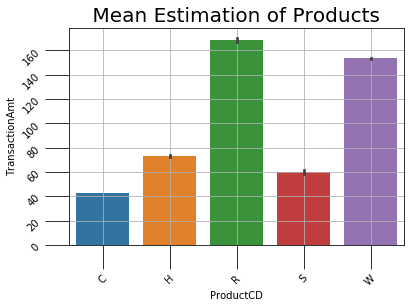

In [56]:

sns.barplot(x="ProductCD", y="TransactionAmt",
            data=train.sort_values("ProductCD"));
plt.title(' Mean Estimation of Products ',fontsize=20)
plt.grid(True)
plt.tick_params(axis ='x', rotation = 45,length =24)
plt.tick_params(axis ='y', rotation = 45,length =24) 


In [65]:
print('Checking the Amount Quantile for each ProductCD')
round(train[['ProductCD', 'TransactionAmt']].groupby('ProductCD').quantile([.25, .5, .75,1]),2).transpose() 

Checking the Amount Quantile for each ProductCD


ProductCD           C                         H                          R  \
                 0.25   0.50  0.75   1.00  0.25  0.50   0.75   1.00   0.25   
TransactionAmt  18.42  31.19  54.1  712.9  35.0  50.0  100.0  500.0  100.0   

ProductCD                                S                         W        \
                 0.50   0.75    1.00  0.25  0.50  0.75    1.00  0.25  0.50   
TransactionAmt  125.0  200.0  1800.0  20.0  35.0  80.0  1550.0  49.0  78.5   

ProductCD                        
                 0.75      1.00  
TransactionAmt  146.0  31937.39

**From the above Mean Estimation PLot and Quantile Plot we observe below:
--> The most expensive Product is R with a median value of 125, mean value of 165 and more than 25% items are sold at price >=200
--> The most cheapest Product is C with a median value of 30.8, mean value of 40 and  75% items are sold at price <= 53**

## Part 4 - Correlation Coefficient

In [66]:
# TODO: code to calculate correlation coefficient

Plot the distribution between the time of day and the purchase amount.
What is the correlation coefficient? Note that some cleaning is necessary to get a meaningful time of day. 

In [67]:
#Filtering only addr2 and Date columns for ditribution visualization
dt_price = train[['TransactionDT','TransactionAmt']]
dt_price= pd.DataFrame(dt_price)

#Adding hour column 

dt_price['hours'] = dt_price.TransactionDT.dt.hour
 

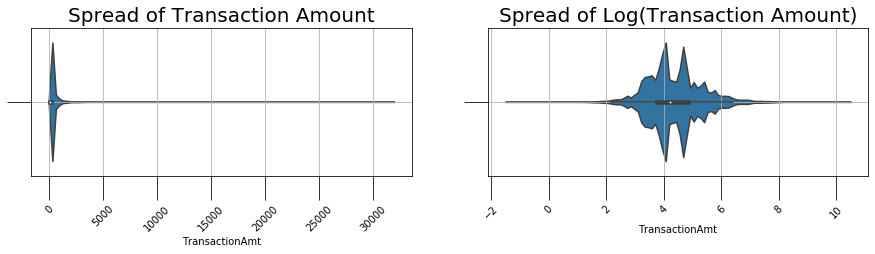

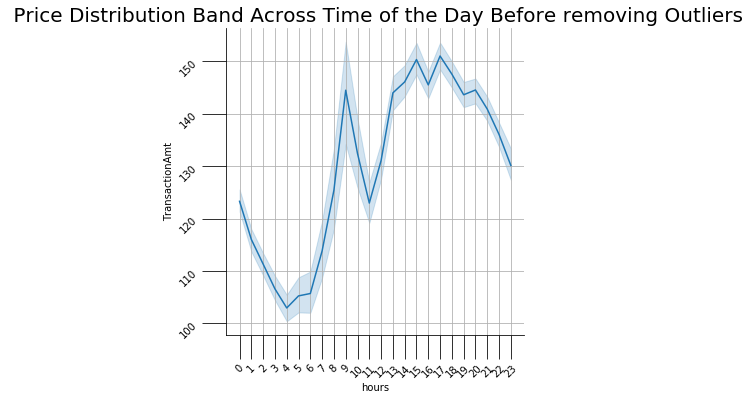

In [80]:
plt.figure(figsize= (15,6))
plt.subplot(2,2,1)
sns.violinplot(x=dt_price['TransactionAmt'])
plt.title('Spread of Transaction Amount',fontsize=20)
plt.grid(True)
plt.tick_params(axis ='x', rotation = 45,length =24)
plt.tick_params(axis ='y', rotation = 45,length =24) 


plt.subplot(2,2,2)
sns.violinplot(x=np.log(dt_price['TransactionAmt']))
plt.title('Spread of Log(Transaction Amount)',fontsize=20)
plt.grid(True)
plt.tick_params(axis ='x', rotation = 45,length =24)
plt.tick_params(axis ='y', rotation = 45,length =24) 

sns.relplot(x="hours", y="TransactionAmt", kind="line", data=dt_price)
plt.title(' Price Distribution Band Across Time of the Day Before removing Outliers',fontsize=20)
plt.grid(True)
plt.xticks(np.arange(0,24,1)) 
plt.tick_params(axis ='x', rotation = 45,length =24)
plt.tick_params(axis ='y', rotation = 45,length =24) 

**From the above Scatter Plot we observe that beyond the transaction amount 200, the data is very sparse and there are outliers**

**Finding Z score and removing the data points that are beyond 3Sigma for finding correlation**

In [82]:

from scipy.stats import zscore
threshold= 3
dt_price["Price_zscore"] = zscore(dt_price["TransactionAmt"])
dt_price["is_outlier"] = dt_price["Price_zscore"].apply(
  lambda x: x <= -threshold or x >= threshold
)
#Filtering out data points that are beyond 3sigma

dt_price_filt= dt_price[dt_price['Price_zscore'] < threshold]
print(" ")
print('\033[1m' + "Shape Before Filtering:", dt_price.shape)
print('\033[1m' + "Shape After Filtering:", dt_price_filt.shape)


 
Shape Before Filtering: (590540, 5)
Shape After Filtering: (580447, 5)


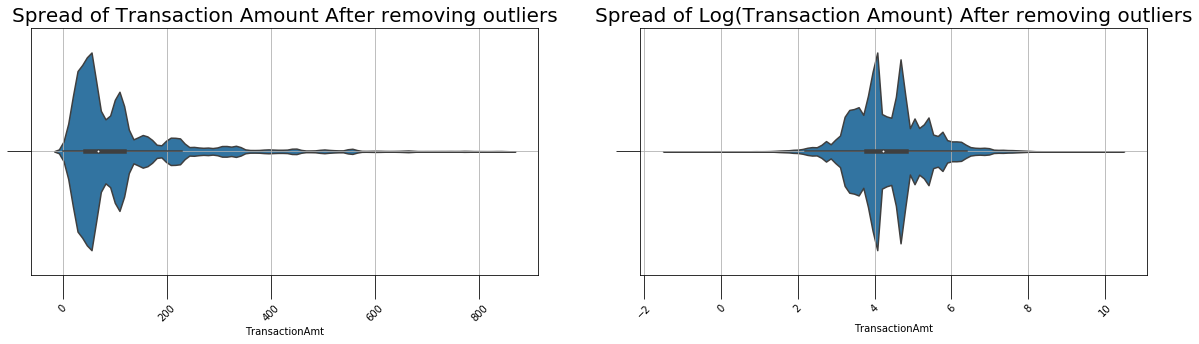

In [86]:
plt.figure(figsize= (20,10))
plt.subplot(2,2,1)
sns.violinplot(x=dt_price_filt['TransactionAmt'])
plt.title('Spread of Transaction Amount After removing outliers',fontsize=20)
plt.grid(True)
plt.tick_params(axis ='x', rotation = 45,length =24)
plt.tick_params(axis ='y', rotation = 45,length =24) 


plt.subplot(2,2,2)
sns.violinplot(x=np.log(dt_price['TransactionAmt']))
plt.title('Spread of Log(Transaction Amount) After removing outliers',fontsize=20)
plt.grid(True)
plt.tick_params(axis ='x', rotation = 45,length =24)
plt.tick_params(axis ='y', rotation = 45,length =24) 



**Finding Correlation on two levels, one at Hourly Level , other at ranking Hour based on Early Morning, Morning to Evening, Evening to Midnight and Midnight to Morning**

In [89]:
from scipy.stats import pearsonr,spearmanr
# calculate Pearson's correlation
dt_price_filt = dt_price_filt[np.isfinite(dt_price_filt['hours'])]
dt_price_filt['hours']= dt_price_filt['hours'].astype(int)

binning= [-1,5,8,12,15,19,23]
dt_price_filt['hr_bucket'] = pd.cut(x=dt_price_filt['hours'], bins= binning,labels=[1,2,3,5,6,4])

median_hr= dt_price_filt.groupby('hours', as_index=False)['TransactionAmt'].median()

median_hrbuk= dt_price_filt.groupby('hr_bucket', as_index=False)['TransactionAmt'].median()

corr, _ = pearsonr(median_hr['hours'], median_hr['TransactionAmt'])
print('\033[1m' + 'Pearsons correlation on Hour Level: %.3f' % corr)

corr, _ = spearmanr(median_hr['hours'], median_hr['TransactionAmt'])
print('\033[1m' + 'Spearmans correlation on Hour Level: %.3f' % corr)


corr, _ = pearsonr(median_hrbuk['hr_bucket'], median_hrbuk['TransactionAmt'])
print('\033[1m' + 'Pearsons correlation on HourBucket: %.3f' % corr)

corr, _ = spearmanr(median_hrbuk['hr_bucket'], median_hrbuk['TransactionAmt'])
print('\033[1m' + 'Spearmans correlation on HourBucket: %.3f' % corr)



Pearsons correlation on Hour Level: 0.513
Spearmans correlation on Hour Level: 0.478
Pearsons correlation on HourBucket: 0.824
Spearmans correlation on HourBucket: 0.794


## Part 5 - Interesting Plot

In [90]:
# TODO: code to generate the plot here.

Create a plot of your own using the dataset that you think reveals something very interesting.
Explain what it is, and anything else you learned.  

Plotting TxnAmount V/s  [hr_bucket, week_of_month, Month] to see if there is any pattern


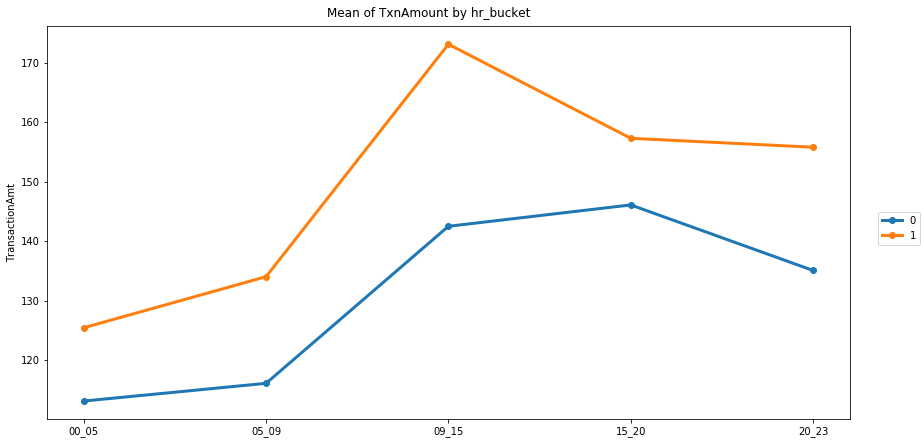

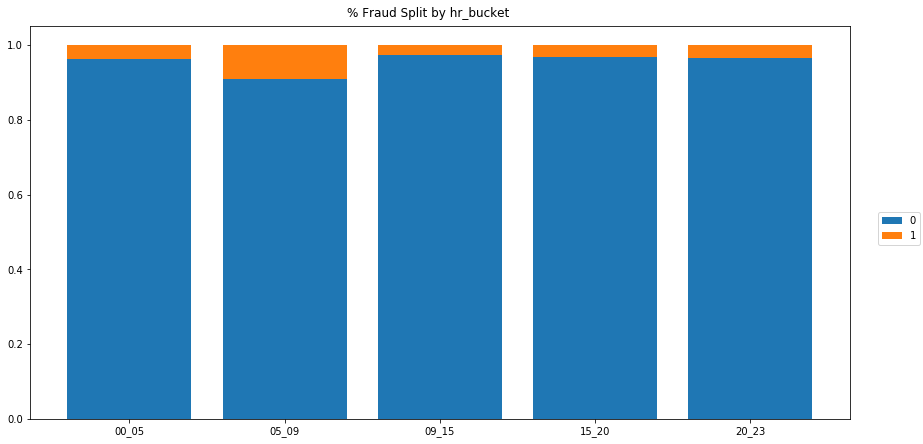

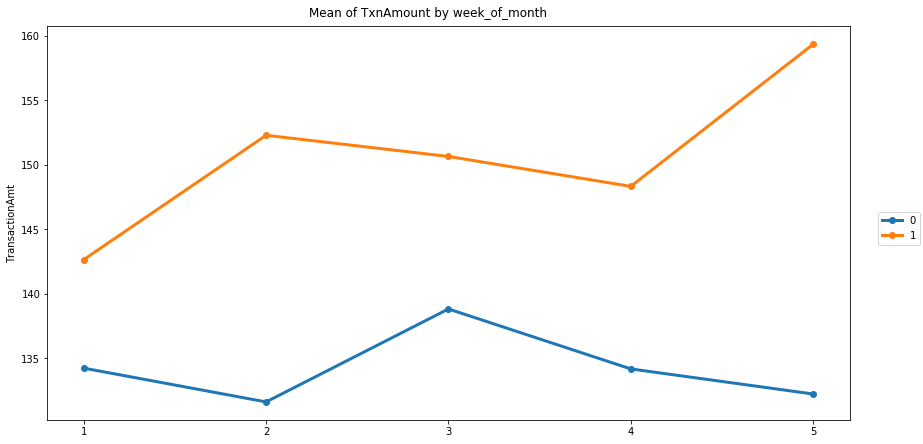

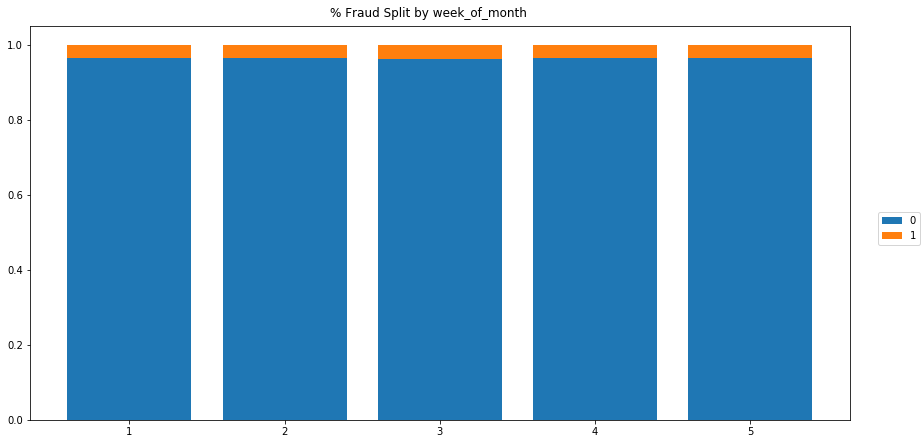

In [91]:
#Time of the day
train['hrs'] = train.TransactionDT.dt.hour
train['hrs']= train['hrs'].astype(int)

binning= [-1,5,9,15,20,23]
buk_nm= ['00_05','05_09','09_15','15_20','20_23']
train['hr_bucket'] = pd.cut(x=train['hrs'], bins= binning,labels=buk_nm)

train['week_of_month'] = (train.TransactionDT.dt.day -1)//7 +1
train['week_of_month']= train['week_of_month'].astype(str)

#train['Month_Week']= train.TransactionDT.dt.weekday
#train['Month_WeekDay']= train['Month_Week'].astype(str)

# train['Month']= train.TransactionDT.dt.month
# train['Month']= train['Month'].astype(str)


print('\033[1m' + 'Plotting TxnAmount V/s  [hr_bucket, week_of_month, Month] to see if there is any pattern') 

var= 'hr_bucket'
dxp.aggplot(agg='TransactionAmt', data=train, groupby=var, hue='isFraud', kind='line', aggfunc='mean',title="Mean of TxnAmount by " + var)
dxp.aggplot(agg=var, data=train,hue='isFraud', normalize=var,stacked=True,title="% Fraud Split by " + var)

var= 'week_of_month'
dxp.aggplot(agg='TransactionAmt', data=train, groupby=var, hue='isFraud', kind='line', aggfunc='mean',title="Mean of TxnAmount by " + var)
dxp.aggplot(agg=var, data=train,hue='isFraud', normalize=var,stacked=True,title="% Fraud Split by " + var)

# var= 'Month'
# dxp.aggplot(agg='TransactionAmt', data=train, groupby=var, hue='isFraud', kind='line', aggfunc='mean',title="Mean of TxnAmount by " + var)
# dxp.aggplot(agg=var, data=train,hue='isFraud', normalize=var,stacked=True,title="% Fraud Split by " + var)

train['week_of_month']= train['week_of_month'].astype(str)
# train['Month']= train['Month'].astype(str)
train['hr_bucket']= train['hr_bucket'].astype(str)


**From above Plots we observe following:
--> During Mid of the Month Fraud Txn amount is 2X of the Non Fraud Txn amount
--> During Early Morning from 5am - 9am, ~20% of the transactions are fraud
--> Week_of_MOnth and Hour_Bucket could be a good predictor**

In [92]:
#Time of the day
test['hrs'] = test.TransactionDT.dt.hour
test['hrs']= test['hrs'].astype(int)

binning= [-1,5,9,15,20,23]
buk_nm= ['00_05','05_09','09_15','15_20','20_23']
test['hr_bucket'] = pd.cut(x=test['hrs'], bins= binning,labels=buk_nm)

test['week_of_month'] = (test.TransactionDT.dt.day -1)//7 +1
test['week_of_month']= test['week_of_month'].astype(str)

test['hr_bucket']= test['hr_bucket'].astype(str)


## Part 6 - Prediction Model

In [93]:
# TODO: code for your final model

Now, try to build a prediction model that works to solve the task.
You are allowed to use  additional variables from the dataset if you wish.
Perhaps it will use linear regression.
Perhaps it will preprocess features 
(e.g. normalize or scale the input vector, convert non-numerical value into float, 
or do a special treatment of missing values). Perhaps it will use a different machine learning approach 
(e.g. nearest neighbors, random forests).


# Feature Preparation

In [94]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [103]:
def print_train_test_columns(train, test):
    print(train.shape)
    print('\033[1m' + "Features in Training Set")
    print(list(train.columns))

    print(' ')
    print(test.shape)
    print('\033[1m' + "Features in Test Set")
    print(list(test.columns))
    
print_train_test_columns(train, test)

(590540, 14)
Features in Training Set
['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'addr1', 'addr2', 'isFraud', 'hrs', 'hr_bucket', 'week_of_month', 'TxnAmt_Log']
 
(506691, 13)
Features in Test Set
['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'addr1', 'addr2', 'hrs', 'hr_bucket', 'week_of_month', 'TxnAmt_Log']


**For categorical Columns if its NA or na or null replacing it with 'empty'**

In [100]:
##For Training Set
cols=train.columns
num_cols=train._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))

for col in cat_cols:
    train[col]=train[col].fillna('empty')

##For Test Set
cols=test.columns
num_cols=test._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))

for col in cat_cols:
    test[col]=test[col].fillna('empty')


**As we saw in Part4 that Transaction Amount has lot of outliers so we will introduce a new varibale for amount in the log scale**

In [101]:
train['TxnAmt_Log']= np.log2(train['TransactionAmt'])
test['TxnAmt_Log']= np.log2(test['TransactionAmt'])

test_id= pd.DataFrame(test['TransactionID'])

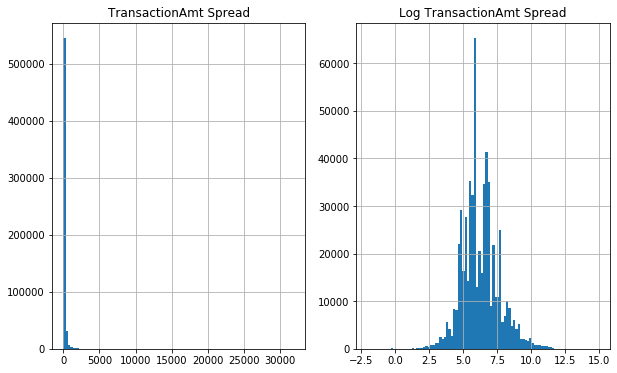

In [125]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('TransactionAmt Spread')
(train_on['TransactionAmt']).hist(bins=100)

plt.subplot(1,2,2)
plt.title('Log TransactionAmt Spread')
np.log2(train_on['TransactionAmt']).hist(bins=100)

**Dropping redundant Columns from the Feature set**

In [349]:
drop_columns = ['TransactionID', 'TransactionDT','addr1']
train_on=[]
train_on = train.drop(drop_columns, axis=1)
print(train_on.shape)

test_on=[]
test_on = test.drop(drop_columns, axis=1)
print(test_on.shape)

(590540, 11)
(506691, 10)


**Reducing the number of categories in the categorical variable of Training Set**

In [350]:
cols=train_on.columns
num_cols=train_on._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))

for cat in cat_cols:
    print("There are "+ str(train_on[cat].nunique()) + " unique " + cat)

#Reducing the categories in the following Variables:
reduce_levels_cat= ['addr2','P_emaildomain']

for var in reduce_levels_cat:
    freq='count'    
    var_c = train_on.groupby(var).size().rename_axis(var).reset_index(name=freq)
    var_c= pd.DataFrame(var_c)
    var_c = var_c.sort_values(by=freq, ascending=False)
    var_c['cumulative_percentage'] = 100*var_c[freq].cumsum()/var_c[freq].sum()

    thres= 80
    var_c = var_c[var_c['cumulative_percentage'] <= thres]
    filt = list(var_c[var])
    train_on[var]= train_on[var].apply(lambda i: i if i in filt else 'other')

print(' ')
print('\033[1m' + "After Labelling Adjustment")    
for cat in cat_cols:
    print("There are "+ str(train_on[cat].nunique()) + " unique " + cat)



There are 5 unique card6
There are 5 unique ProductCD
There are 5 unique week_of_month
There are 5 unique card4
There are 5 unique hr_bucket
There are 75 unique addr2
There are 60 unique P_emaildomain
 
After Labelling Adjustment
There are 5 unique card6
There are 5 unique ProductCD
There are 5 unique week_of_month
There are 5 unique card4
There are 5 unique hr_bucket
There are 1 unique addr2
There are 5 unique P_emaildomain


Text(0.5, 1.0, 'Data Completenss Check in Training Set')

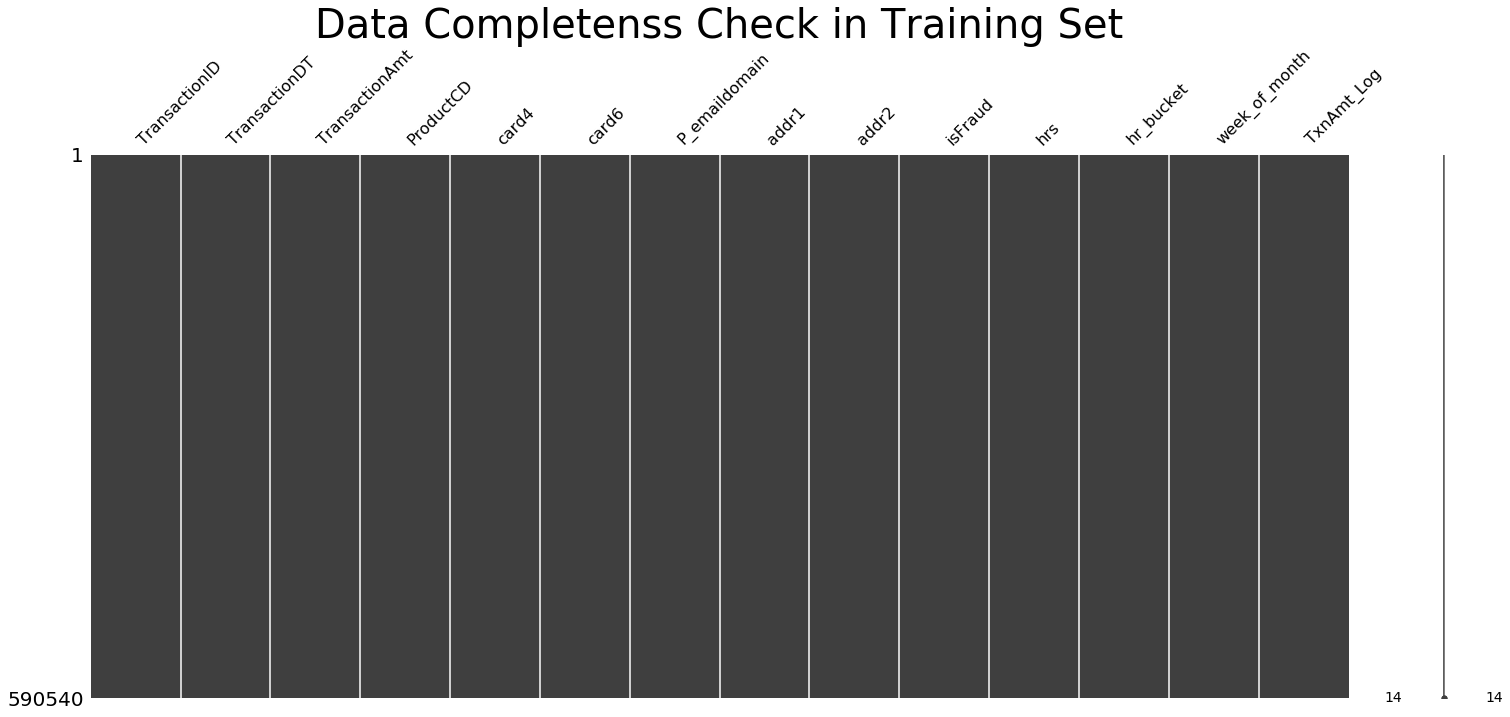

In [351]:
#Checking Nullity and Data Completeness
import missingno as msno
msno.matrix(train)
plt.title('Data Completenss Check in Training Set', size = 40)

**Reducing the number of categories in the categorical variable of Test Set**

In [352]:
cols=test_on.columns
num_cols=test_on._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))


for cat in cat_cols:
    print("There are "+ str(test_on[cat].nunique()) + " unique " + cat)

#Reducing the categories in the following Variables:
reduce_levels_cat= ['addr2','P_emaildomain']

for var in reduce_levels_cat:
    freq='count'    
    var_c = test_on.groupby(var).size().rename_axis(var).reset_index(name=freq)
    var_c= pd.DataFrame(var_c)
    var_c = var_c.sort_values(by=freq, ascending=False)
    var_c['cumulative_percentage'] = 100*var_c[freq].cumsum()/var_c[freq].sum()

    thres= 80
    var_c = var_c[var_c['cumulative_percentage'] <= thres]
    filt = list(var_c[var])
    test_on[var]= test_on[var].apply(lambda i: i if i in filt else 'other')

print(' ')
print('\033[1m' + "After Labelling Adjustment")    
for cat in cat_cols:
    print("There are "+ str(test_on[cat].nunique()) + " unique " + cat)


There are 4 unique card6
There are 5 unique ProductCD
There are 5 unique week_of_month
There are 5 unique card4
There are 5 unique hr_bucket
There are 1 unique addr2
There are 5 unique P_emaildomain
 
After Labelling Adjustment
There are 4 unique card6
There are 5 unique ProductCD
There are 5 unique week_of_month
There are 5 unique card4
There are 5 unique hr_bucket
There are 1 unique addr2
There are 3 unique P_emaildomain


In [353]:
print_train_test_columns(train_on,test_on)

(590540, 11)
Features in Training Set
['TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'addr2', 'isFraud', 'hrs', 'hr_bucket', 'week_of_month', 'TxnAmt_Log']
 
(506691, 10)
Features in Test Set
['TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'addr2', 'hrs', 'hr_bucket', 'week_of_month', 'TxnAmt_Log']


# Creating onehotencoder for the categorical  Variables in Training and Test Set

In [354]:
y= train_on['isFraud']
train_on = train_on.drop(['isFraud'], axis=1)


In [355]:
one_hot_vectors_train = pd.get_dummies(train_on)

one_hot_vectors_test= pd.get_dummies(test_on)

In [356]:
print_train_test_columns(one_hot_vectors_train,one_hot_vectors_test)

(590540, 34)
Features in Training Set
['TransactionAmt', 'hrs', 'TxnAmt_Log', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_american express', 'card4_discover', 'card4_empty', 'card4_mastercard', 'card4_visa', 'card6_charge card', 'card6_credit', 'card6_debit', 'card6_debit or credit', 'card6_empty', 'P_emaildomain_empty', 'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com', 'P_emaildomain_other', 'P_emaildomain_yahoo.com', 'addr2_other', 'hr_bucket_00_05', 'hr_bucket_05_09', 'hr_bucket_09_15', 'hr_bucket_15_20', 'hr_bucket_20_23', 'week_of_month_1', 'week_of_month_2', 'week_of_month_3', 'week_of_month_4', 'week_of_month_5']
 
(506691, 31)
Features in Test Set
['TransactionAmt', 'hrs', 'TxnAmt_Log', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_american express', 'card4_discover', 'card4_empty', 'card4_mastercard', 'card4_visa', 'card6_charge card', 'card6_credit', 'card6_debit', 'card6_empty', 'P_emaildomain_gm

In [357]:
training_features_sel=list(set(one_hot_vectors_train.columns).intersection(one_hot_vectors_test.columns))
print('Final Features Selected for Training the Model')
print(' ')
print('\033[1m' + str(training_features_sel))

Final Features Selected for Training the Model
 
['ProductCD_W', 'hrs', 'week_of_month_3', 'ProductCD_S', 'P_emaildomain_yahoo.com', 'P_emaildomain_other', 'hr_bucket_20_23', 'card4_empty', 'week_of_month_5', 'ProductCD_R', 'card6_charge card', 'card6_debit', 'week_of_month_4', 'P_emaildomain_gmail.com', 'TxnAmt_Log', 'TransactionAmt', 'card4_discover', 'card4_visa', 'week_of_month_2', 'card6_empty', 'card4_mastercard', 'ProductCD_C', 'addr2_other', 'ProductCD_H', 'week_of_month_1', 'hr_bucket_00_05', 'hr_bucket_09_15', 'card4_american express', 'hr_bucket_15_20', 'card6_credit', 'hr_bucket_05_09']


In [358]:
pick_features= ['ProductCD_W', 'hrs', 'week_of_month_3', 'ProductCD_S','P_emaildomain_yahoo.com', 'P_emaildomain_other',
                'hr_bucket_20_23', 'card4_empty', 'week_of_month_5', 'ProductCD_R', 'card6_charge card',
                'card6_debit', 'week_of_month_4', 'P_emaildomain_gmail.com', 'TxnAmt_Log', 'TransactionAmt',
                'card4_discover', 'card4_visa', 'week_of_month_2', 'card6_empty', 'card4_mastercard',
                'ProductCD_C', 'addr2_other', 'ProductCD_H', 'week_of_month_1', 'hr_bucket_00_05',
                'hr_bucket_09_15', 'card4_american express', 'hr_bucket_15_20', 'card6_credit', 'hr_bucket_05_09']


In [359]:
train_final_features= one_hot_vectors_train[pick_features]
test_final_features=one_hot_vectors_test[pick_features]

# Checking Correlation Matrix of the Variables in Training Set

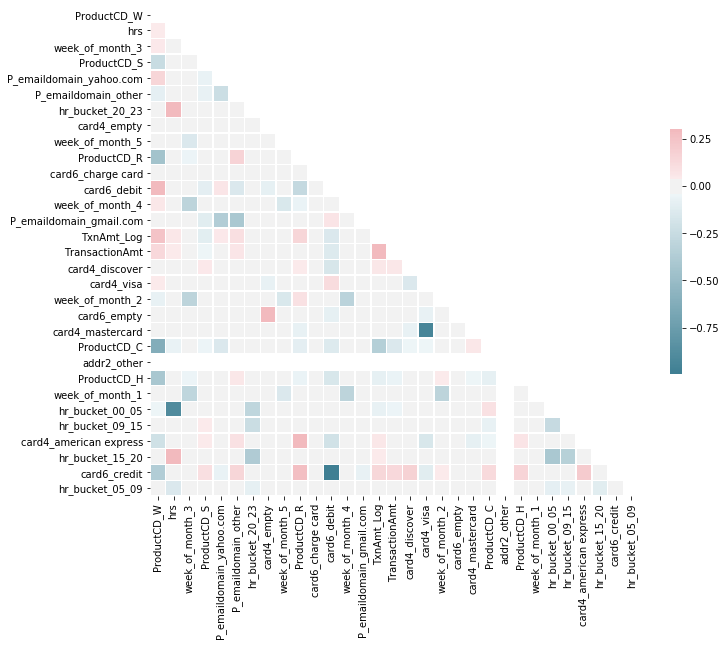

In [360]:
# Compute the correlation matrix
corr = train_final_features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [361]:
X=train_final_features.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=44)

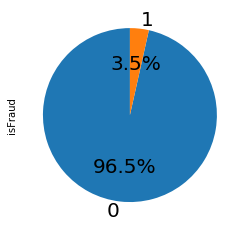

In [362]:
y.value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=90, shadow=False,  legend = False, fontsize=20)

**As we can observe Minority Fraud samples are only 3.5%, so its a highly unblanaced class set**

# Implementing the Model with UnBalanced Classes
**Modelling without OverSampling the minority class**

Accuracy of logistic regression classifier on test set: 96.53%
Confusion Matrix
[[171015      3]
 [  6139      5]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    171018
           1       0.62      0.00      0.00      6144

    accuracy                           0.97    177162
   macro avg       0.80      0.50      0.49    177162
weighted avg       0.95      0.97      0.95    177162



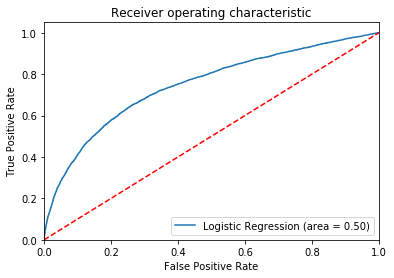

In [363]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = logreg.predict(X_test)
#print('\033[1m' + 'Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
#print(round(100*accuracy_score(y_test, y_pred), 2))

print('\033[1m' + 'Accuracy of logistic regression classifier on test set: ' + str(round(100*accuracy_score(y_test, y_pred), 2)) + '%')


prob = logreg.predict_proba(X_test)



from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print('\033[1m' + 'Confusion Matrix')
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()



**We observe that the Model is able not able to predict the Non Fraud Class, as the f1-score for Fraud =0 , this is probably because the Fraud samples are very less in our training set, hence we need to upsample the fraud cases** 

# Implementing the Model with Balanced Classes

# Over-sampling the Minority Class

In [364]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['isFraud'])

# we can Check the numbers of our data
print('\033[1m' + "# Oversampled data is ",len(os_data_X))
print('\033[1m' + "# Non Fraud in oversampled data",len(os_data_y[os_data_y['isFraud']==0]))
print('\033[1m' + "# Fraud",len(os_data_y[os_data_y['isFraud']==1]))
print('\033[1m' + "Proportion of Non Fraud data in oversampled data is ",len(os_data_y[os_data_y['isFraud']==0])/len(os_data_X))
print('\033[1m' + "Proportion of Fraud data in oversampled data is ",len(os_data_y[os_data_y['isFraud']==1])/len(os_data_X))


# Oversampled data is  797718
# Non Fraud in oversampled data 398859
# Fraud 398859
Proportion of Non Fraud data in oversampled data is  0.5
Proportion of Fraud data in oversampled data is  0.5


# Logistic Regression Model Fitting

In [365]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y['isFraud'], test_size=0.3, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Predicting the test set results and calculating the accuracy

In [366]:
from sklearn.metrics import accuracy_score
y_pred = logreg.predict(X_test)
print('\033[1m' + 'Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
#print(round(100*accuracy_score(y_test, y_pred), 2))

prob = logreg.predict_proba(X_test)


Accuracy of logistic regression classifier on test set: 0.70


# Confusion Matrix

In [367]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[89924 29540]
 [41992 77860]]


# Compute precision, recall, F-measure and support

In [368]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.75      0.72    119464
           1       0.72      0.65      0.69    119852

    accuracy                           0.70    239316
   macro avg       0.70      0.70      0.70    239316
weighted avg       0.70      0.70      0.70    239316



# ROC Curve

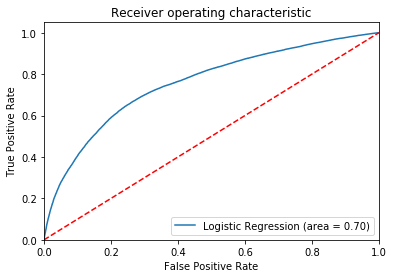

In [369]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()



In [370]:
y_pred= pd.DataFrame(y_pred)
y_pred.columns = ['is_Fraud']
y_pred.groupby('is_Fraud').size().rename_axis('is_Fraud').reset_index(name='count')

,is_Fraud,count
0,0,131916
1,1,107400


# Predicting Fraud in the Test Data

In [200]:
Test_Features=test_final_features.copy()

In [201]:
test_pred= pd.DataFrame(logreg.predict_proba(Test_Features)[:,1])

In [203]:
submission=pd.DataFrame()
submission= test_id.copy()

In [204]:
submission['isFraud']=round(test_pred,3)

In [205]:
submission.shape

(506691, 2)

In [206]:
submission.head()

,TransactionID,isFraud
0,3663549,0.285
1,3663550,0.202
2,3663551,0.302
3,3663552,0.501
4,3663553,0.292


In [208]:
file_version= 'submission_2.csv'

In [214]:
submission.to_csv('/Users/mehar/Downloads/Stony_Brook_University/Fall2019/DataScience/ieee-fraud-detection/Submission/'+ str(file_version), index=False)


# Applying XGBoost Algorithm

# Finding Top Contributing features

In [373]:
x_train, x_test, y_train, y_test = train_test_split(train_on, y, test_size=0.2, random_state=123)

[0]	train-rmse:0.478292	test-rmse:0.478302
[50]	train-rmse:0.179743	test-rmse:0.180166
[99]	train-rmse:0.175101	test-rmse:0.175849


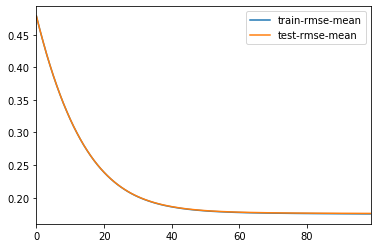

In [374]:
from sklearn import model_selection, preprocessing
import xgboost as xgb

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=100, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [375]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

[19:20:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


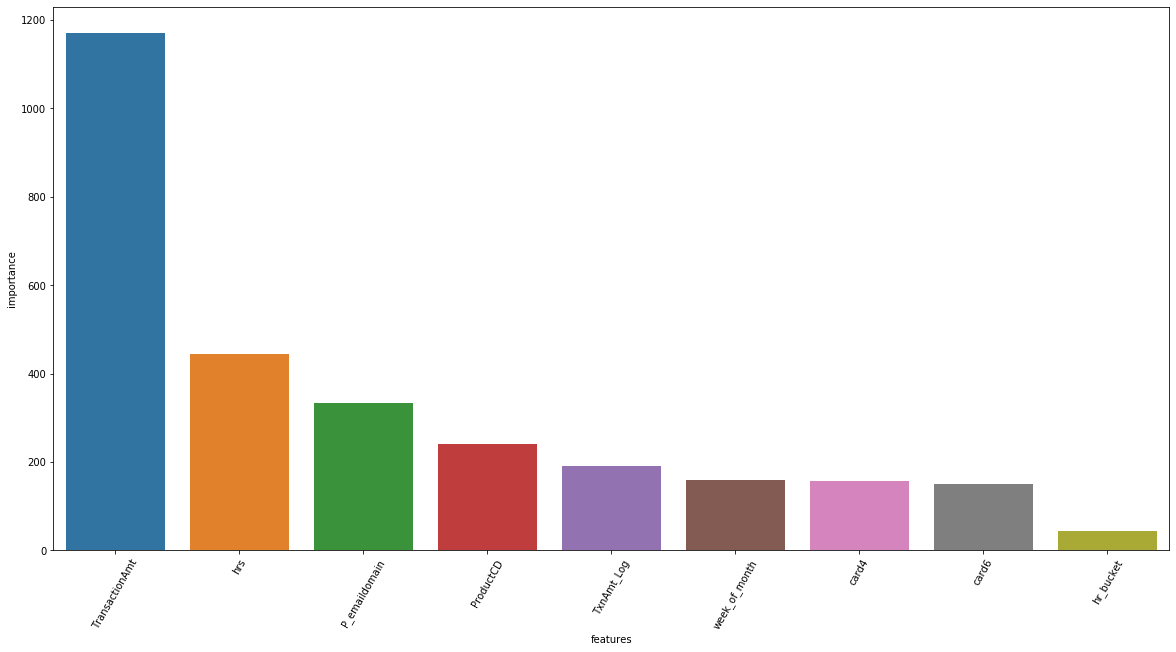

In [376]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")

In [390]:
ypred = model.predict(dtest,ntree_limit=model.best_ntree_limit)

In [395]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, ypred)

# Root Mean Square Error

In [413]:
print('MSE'+ str(mse))

MSE0.032094926


In [399]:
for c in test_on.columns:
    if test_on[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test_on[c].values)) 
        test_on[c] = lbl.transform(list(test_on[c].values))


In [401]:
test_submission= xgb.DMatrix(test_on)

In [403]:
submission_pred = model.predict(test_submission,ntree_limit=model.best_ntree_limit)
submission_pred=pd.DataFrame(submission_pred)

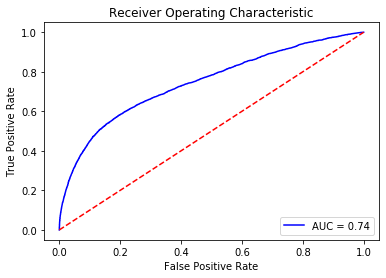

In [405]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')
    
buildROC(y_test,ypred)    

In [410]:
submission=pd.DataFrame()
submission= test_id.copy()

submission['isFraud']=round(submission_pred,3)

submission.shape

submission.head()

file_version= 'submission_xgboost.csv'

submission.to_csv(file_version, index=False)


## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.


Kaggle Link: https://www.kaggle.com/ar1994

Highest Rank: 5238

Score: 0.8161

Number of entries: 3

INCLUDE IMAGE OF YOUR KAGGLE RANKING

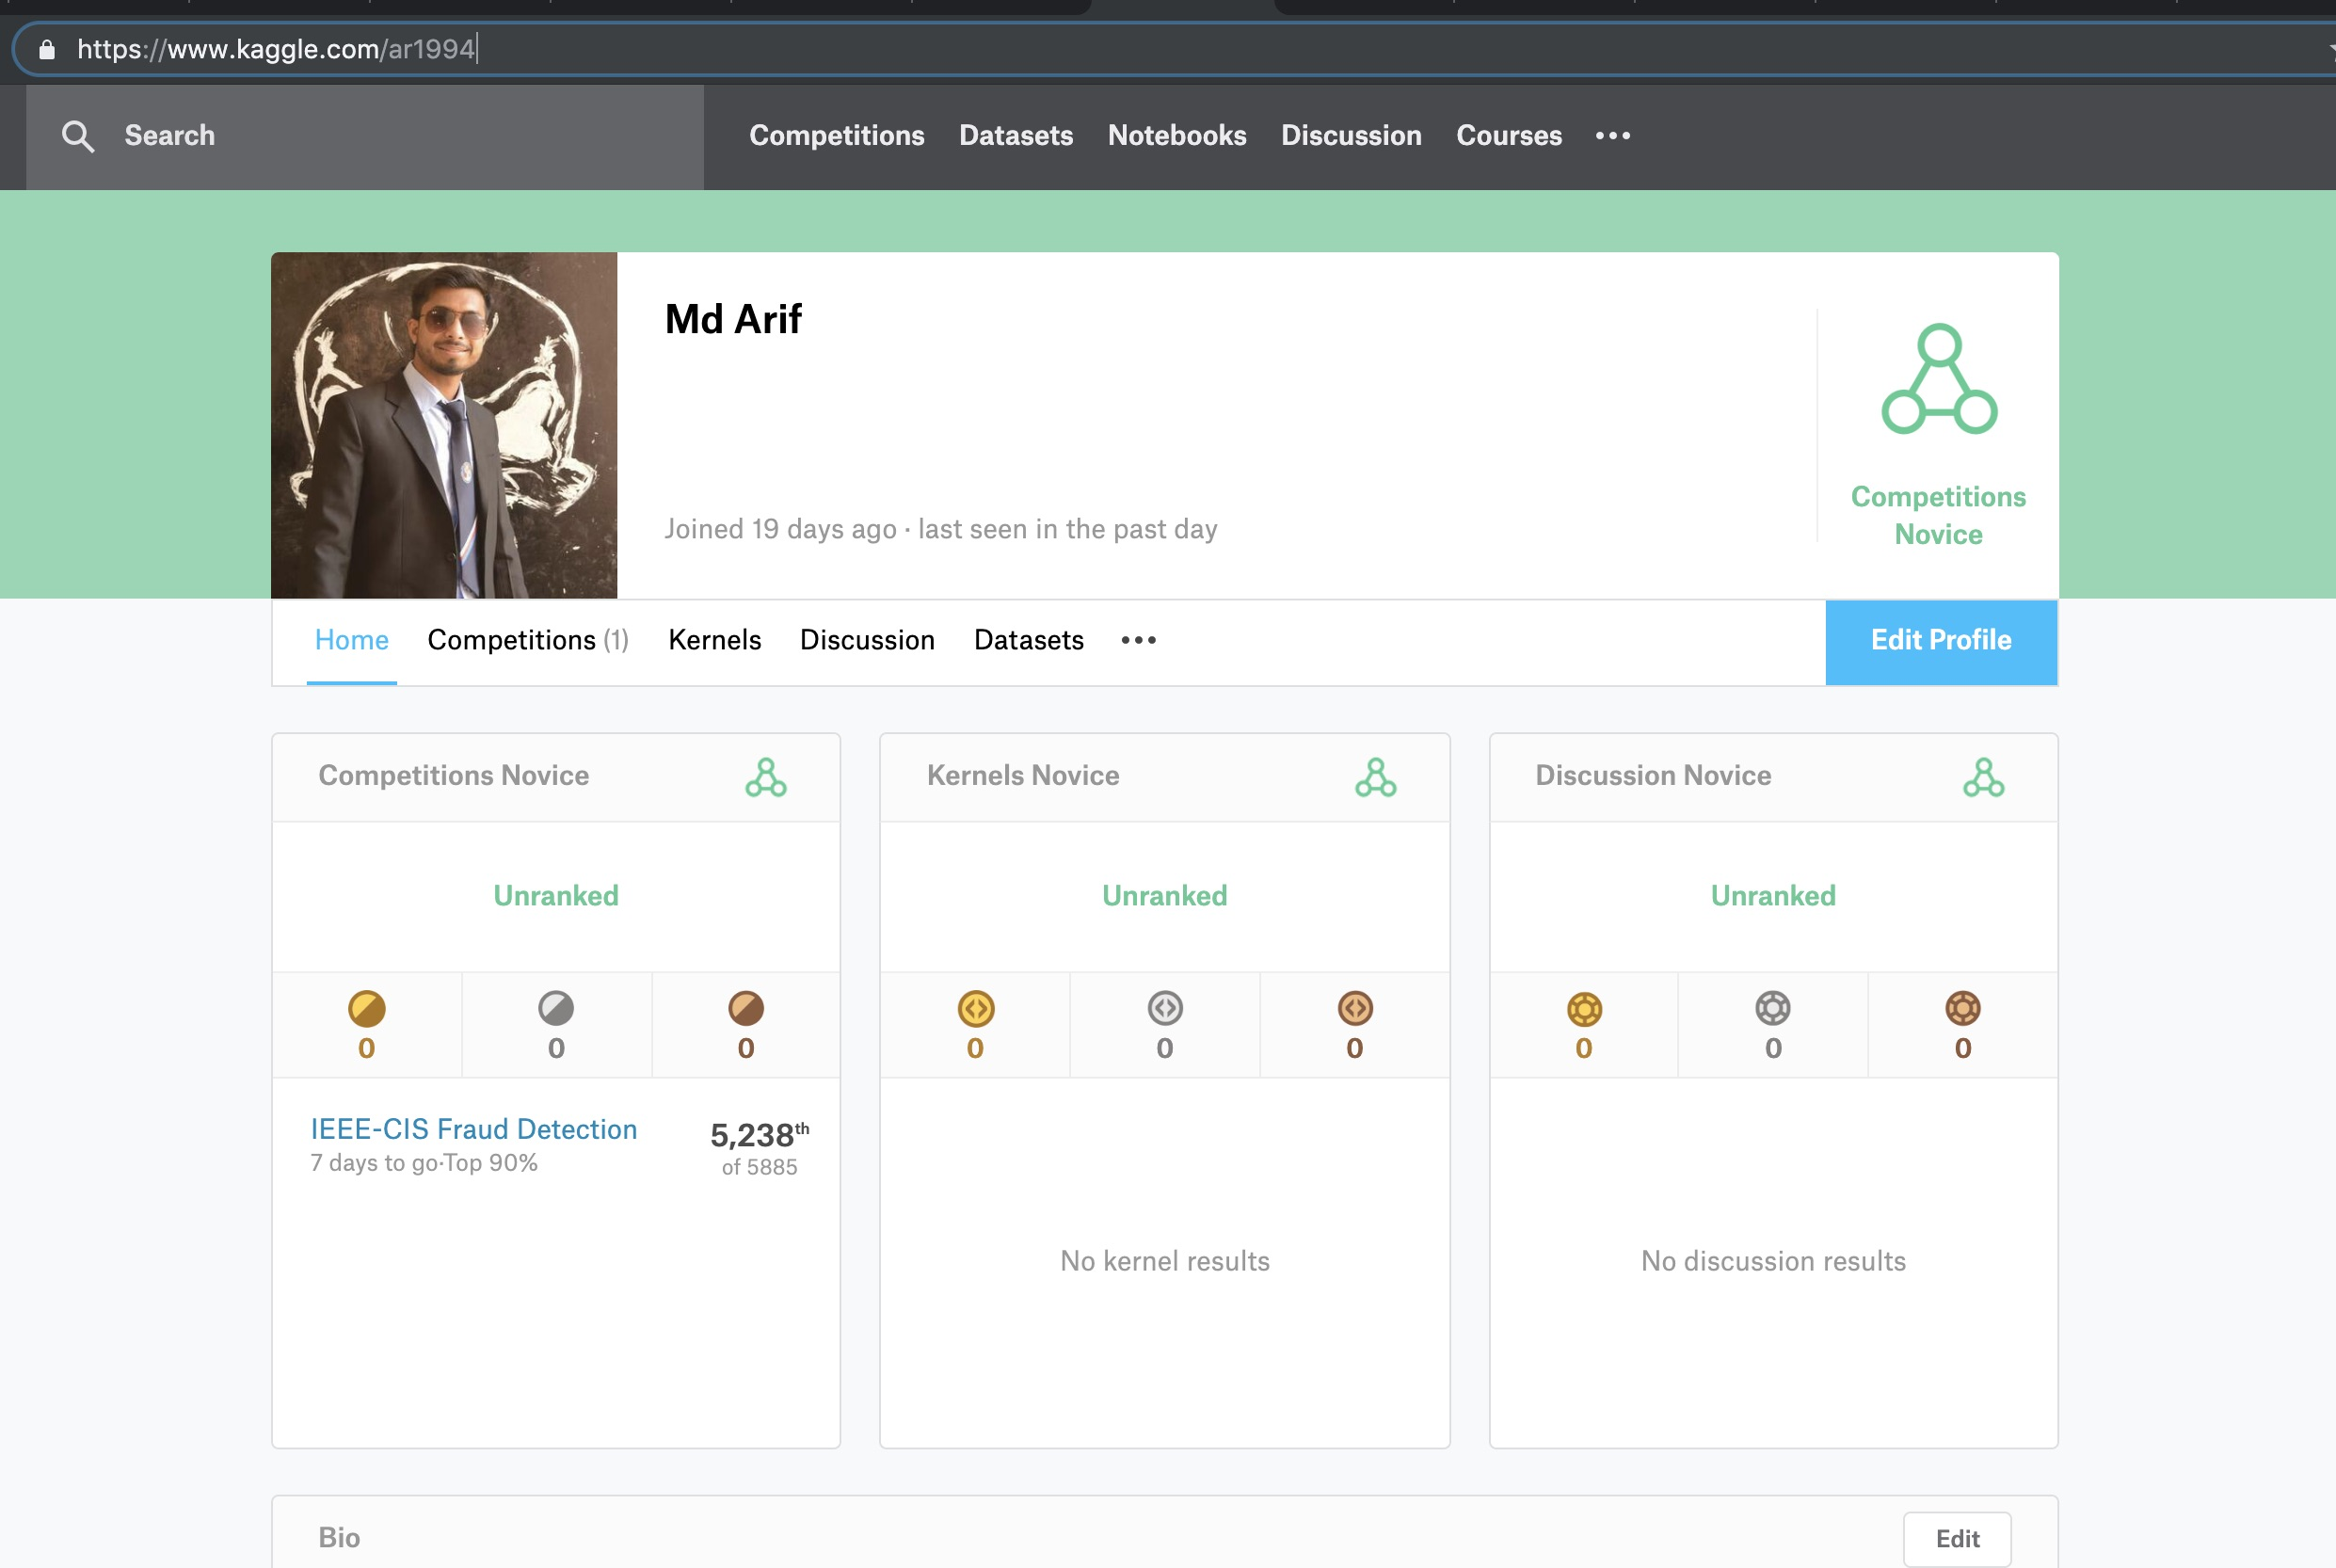

**References**

#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
#https://www.kaggle.com/inversion/ieee-simple-xgboost